# Data importation

In [1]:
import random
import numpy as np
from sklearn import svm
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
import nltk
import csv
import pandas as pd
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import networkx as nx
import re

%matplotlib inline

In [2]:
info = pd.read_csv(
    "node_information.csv", 
    header= None, 
    names=["Id", "year", "title", "authors", "journal", "abstract"],
    sep=",",
    index_col = 0
)

In [3]:
X_train = pd.read_csv("training_set.txt", sep=" ", header=None)
X_test = pd.read_csv("testing_set.txt", sep=" ", header=None)
y_train = X_train[2]
X_train.drop([2], axis = 1, inplace = True)

print info.shape, X_train.shape, X_test.shape

(27770, 5) (615512, 2) (32648, 2)


# Feature Preprocess

- list_authors is the list of authors in the papers
- list_universities is the list where the authors are from

In [4]:
def universities_to_keep(authors, universities):
    while('(' in authors and ')' in authors):
        universities.append( authors[authors.find('(')+1 : authors.find(')')] )
        authors = authors[: authors.find('(')] + authors[ authors.find(')')+1 : ]
            
    if '(' in authors:
        universities.append( authors[authors.find('(')+1 : ])
        authors = authors[: authors.find('(')]
    
    return authors, universities


def name_to_keep(author):
    if len(author.split(' ')) <= 1:
        return author
    
    while( author[0] == ' ' and len(author) > 0):
        author = author[1:]
    while( author[-1] == ' ' and len(author) > 0):
        author = author[:-1]
    
    author = author.replace('.', '. ')
    author = author.replace('.  ', '. ')
    name_to_keep = author.split(' ')[0][0] + '. ' + author.split(' ')[-1]

    return name_to_keep

# Transform concatenated names of authors to a list of authors 
list_authors = []
list_universities = []

info['authors'] = info['authors'].replace(np.nan, 'missing')
for authors in info['authors']:
    if authors != 'missing':
        ### split the different authors
        authors = authors.lower()
        
        ### Find the universities included in the name
        universities = []
        authors, universities = universities_to_keep(authors, universities)
        
        ### Split the authors
        authors = re.split(',|&', authors)
        
        ### For each author, check if university, and store it. Also, keep just the names (To be improved)
        authors_in_article = []      
        for author in authors:
            if author != ' ':
                authors_in_article.append(name_to_keep(author))
            
        list_universities.append(universities)
        list_authors.append(authors_in_article)
    else:
        list_universities.append(['missing'])
        list_authors.append(['missing'])   
        
info['authors'] = list_authors
info['universities'] = list_universities

# Topologic features

In [5]:
def make_graph(X_train, y_train, X_test):
    X_train = pd.concat([X_train, y_train], axis = 1)
    X_train = X_train.values
    G = nx.DiGraph()
    for i in range(X_train.shape[0]):
        source = X_train[i,0]
        target = X_train[i,1]
        G.add_node(source)
        G.add_node(target)
        if X_train[i,-1] == 1:
            G.add_edge(source,target)
            
    X_test = X_test.values
    for i in range(X_test.shape[0]):
        source = X_test[i,0]
        target = X_test[i,1]
        G.add_node(source)
        G.add_node(target)
        
    return G  

In [6]:
G = make_graph(X_train, y_train, X_test)  

In [7]:
def create_topologic_features(X, G):
    X_ = X.copy()
    X = X.values
    
    X_['Betweeness centrality'] = compute_betweeness_array(X, G)
    X_['Number common neighbours'] = make_common_neighbors(X, G)
    X_['Jaccard coefficienf'] = make_jaccard(X, G)
    diff_deg, to_deg = compute_diff_inlinks(X, G)
    X_['Difference in inlinks coefficient'] = diff_deg
    X_["Number of times to cited"] = to_deg
    X_['Same cluster'] = same_community(X,G)
    return X_

In [8]:
%%time
from create_topologic_features import create_topologic_features
X_train = create_topologic_features(X_train, G)
X_test = create_topologic_features(X_test, G)

CPU times: user 4min 21s, sys: 2.38 s, total: 4min 24s
Wall time: 4min 36s


# Semantic features
- Cosine similarity within the titles as tf-idf
- Cosine similarity within the abstracts as tf-idf
- Cosine similarity within the titles as word2vec
- Cosine similarity within the abstracts as word2vec

### To try
- Difference cosine similarities?
- Keep the stopwords or not?
- Stemmise the words of not?

In [9]:
%%time
from semantic_features import *


sentences = []  # Initialize an empty list of sentences
word_list_abstract=pd.Series(index=info.index,dtype=np.str)
word_list_title=pd.Series(index=info.index,dtype=np.str)

for idx in info.index:
    w_list_a = text_to_sentences(info.loc[idx,"abstract"], tokenizer, True)
    sentences += w_list_a
    word_list_abstract[idx]= w_list_a
    w_list_t = text_to_sentences(info.loc[idx,"title"], tokenizer, True)
    sentences += w_list_t
    word_list_title[idx]= w_list_t

num_features = 200
model = load_model(sentences, train = False, num_features = num_features, min_word_count = 10, num_workers = 4, context = 10, downsampling = 1e-3)


centroid_title = dict(zip(info.index, getAvgFeatureVecs(info.title.values, model, num_features)))
centroid_abstract = dict(zip(info.index, getAvgFeatureVecs(info.abstract.values, model, num_features)))


# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster
word_vectors = model.syn0
num_clusters = word_vectors.shape[0] / 5

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( model.index2word, idx ))

# Pre-allocate an array for the training set bags of centroids (for speed)
bag_centroids_abstract = {}
#centroids_title = {}
# Transform the training set reviews into bags of centroids
for review, idx in zip(word_list_abstract, word_list_abstract.index):
    bag_centroids_abstract[idx] = create_bag_of_centroids(review[0], word_centroid_map)
#for review, idx in zip(word_list_title, word_list_title.index):
#    centroids_title[idx] = create_bag_of_centroids( review[0], word_centroid_map )


[nltk_data] Downloading package punkt to /home/bat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
CPU times: user 11min 32s, sys: 16 s, total: 11min 48s
Wall time: 9min 12s


/home/bat/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [10]:
w_l_title = info.title.apply(lambda x: text_to_wordlist(x, True))
w_l_abstract = info.abstract.apply(lambda x: text_to_wordlist(x, True))

In [11]:

from scipy.spatial.distance import cosine

   
def compute_cosines(centroids_dic, X):
    bag = []
    for idx, row in X.iterrows():
        
        condition = (np.isnan(centroids_dic[row[0]]).any() or np.isnan(centroids_dic[row[1]]).any())
        if condition:
            bag.append(0)
        else:
            bag.append(cosine(centroids_dic[row[0]], centroids_dic[row[1]]))

    return np.array(bag)
####Jaccard####
def jaccard(a, b):
    """
    Adapted Jaccard for list of words
    """
    if len(a) + len(b) < 1:
        return 0
    else :
        c = set(a).intersection(set(b))
        return float(len(c)) / (len(set(a)) + len(set(b)) - len(set(c)))

def compute_jaccard(list_of_words_dic, X):
    """
    Applying Jaccard to an array of data
    """
    bag=[jaccard(list_of_words_dic[x[0]], list_of_words_dic[x[1]]) for x in X]
    return np.array(bag)

def create_nlp_features(X, centroid_title, centroid_abstract, bag_centroids_abstract, w_l_title, w_l_abstract):
    X_ = X.copy()
    
    X_['Jaccard_title'] = compute_jaccard(w_l_title, X.values)
    X_['Jaccard_abstract'] = compute_jaccard(w_l_abstract, X.values)
    X_['CosineD_title_centroid'] = compute_cosines(centroid_title,X)
    X_['CosineD_abstract_centroid'] = compute_cosines(centroid_abstract,X)
    X_['CosineD_abstract_bag_centroids'] = compute_cosines(bag_centroids_abstract,X)
   
    
    return X_


In [12]:
%%time
X_train = create_nlp_features(
    X_train, centroid_title, centroid_abstract, bag_centroids_abstract, w_l_title, w_l_abstract)
X_test = create_nlp_features(
    X_test,centroid_title, centroid_abstract, bag_centroids_abstract, w_l_title, w_l_abstract)

CPU times: user 15min 53s, sys: 2.28 s, total: 15min 56s
Wall time: 15min 59s


/home/bat/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: FutureWarning: scalar indexers for index type Int64Index should be integers and not floating point


# Attribute features

- Difference in publication year
- Number of common authors
- Self-citation
- Same journal
- Number of times "to" cited (Attraction of the "to" paper)

### To try
- Number of times each author of "to" cited [Sum of these number of times] ?
- Number of times each journal cited?
- Number of same university??

In [13]:
%%time
from create_attribute_features import create_attribute_features
X_train = create_attribute_features(X_train,info)
X_test = create_attribute_features(X_test,info)

CPU times: user 11min 20s, sys: 3.36 s, total: 11min 24s
Wall time: 11min 22s


# Author Graph features

In [14]:
%%time 

from author_graph import make_graph_authors, create_topologic_features_authors

G_authors = make_graph_authors(X_train, y_train, info)
X_train = create_topologic_features_authors(X_train, G_authors, info, betweeness = True, common_neigh_and_jacc = True, inlinks = True)
X_test = create_topologic_features_authors(X_test, G_authors, info,  betweeness = True, common_neigh_and_jacc = True, inlinks = True)

creating cluster features
cluster features created
creating cluster features
cluster features created
CPU times: user 27min 47s, sys: 6.69 s, total: 27min 54s
Wall time: 27min 54s


# NEW FEATURES

# END

In [17]:
X_train.head()

,0,1,Betweeness centrality,Number common neighbours,Jaccard coefficienf,Difference in inlinks coefficient,Number of times to cited,Same cluster,Jaccard_title,Jaccard_abstract,...,Authors Normalized number same cluster,Authors clusters jaccard,Authors betweeness,Authors common neighbors,Authors jaccard,Authors max difference in inlinks,Authors sum difference in inlinks,Authors max of times to cited,Authors sum of times to cited,Authors of times to cited
0,9510123,9502114,-0.000216,1,0.058824,5,8,0,0.166667,0.059701,...,0,0,1.080947,636,0.097952,-5247,-4982,426,161,154.0
1,9707075,9604178,-0.002449,20,0.097087,113,124,1,0.000000,0.107692,...,1,1,-0.063470,413,0.324430,363,682,1086,758,543.0
2,9312155,9506142,-0.000144,0,0.000000,1,2,0,0.000000,0.026490,...,0,0,-0.005749,1,0.023256,14,13,15,15,15.0
3,9911255,302165,0.000216,0,0.000000,-2,2,1,0.000000,0.041237,...,1,1,-0.056456,291,0.266728,222,214,667,667,667.0
4,9701033,209076,-0.000612,0,0.000000,-5,2,0,0.000000,0.058824,...,0,0,1.116592,134,0.020685,-5393,-5389,19,15,9.5


In [18]:
X_test.head()

,0,1,Betweeness centrality,Number common neighbours,Jaccard coefficienf,Difference in inlinks coefficient,Number of times to cited,Same cluster,Jaccard_title,Jaccard_abstract,...,Authors Normalized number same cluster,Authors clusters jaccard,Authors betweeness,Authors common neighbors,Authors jaccard,Authors max difference in inlinks,Authors sum difference in inlinks,Authors max of times to cited,Authors sum of times to cited,Authors of times to cited
0,9807076,9807139,0.001476,0,0.000000,-46,3,1,0.111111,0.089744,...,0.333333,0.5,0.069564,424,0.275325,-383,-1352,678,539,339
1,109162,1182,0.009291,24,0.074303,-61,39,1,0.111111,0.075000,...,1.000000,1.0,0.082327,302,0.258120,-145,277,719,297,215
2,9702187,9510135,-0.018582,59,0.065338,517,726,1,0.166667,0.080000,...,0.500000,0.5,-0.819018,2465,0.374677,3183,2003,5408,5408,5408
3,111048,110115,-0.000504,21,0.221053,5,16,1,0.083333,0.106061,...,0.666667,0.5,-0.070829,358,0.229487,577,1275,1680,872,532
4,9910176,9410073,-0.005150,0,0.000000,143,144,1,0.153846,0.136364,...,0.333333,0.5,-0.143498,289,0.135681,1108,3146,3367,1329,1171


In [19]:
#X_train=X_train.drop([0,1], axis = 1) 
#X_test = X_test.drop([0,1], axis = 1)

In [20]:
path = "submit_data/"
X_train.to_csv(path+"X_train.csv")
X_test.to_csv(path+"X_test.csv")
y_train.to_csv(path+"y_train.csv")
#y_test.to_csv(path+"y_test.csv")

NameError: name 'y_test' is not defined

# Classifier

In [21]:
X_train

,0,1,Betweeness centrality,Number common neighbours,Jaccard coefficienf,Difference in inlinks coefficient,Number of times to cited,Same cluster,Jaccard_title,Jaccard_abstract,...,Authors Normalized number same cluster,Authors clusters jaccard,Authors betweeness,Authors common neighbors,Authors jaccard,Authors max difference in inlinks,Authors sum difference in inlinks,Authors max of times to cited,Authors sum of times to cited,Authors of times to cited
0,9510123,9502114,-0.000216,1,0.058824,5,8,0,0.166667,0.059701,...,0.000000,0.000000,1.080947,636,0.097952,-5247,-4982,426,161,154.0
1,9707075,9604178,-0.002449,20,0.097087,113,124,1,0.000000,0.107692,...,1.000000,1.000000,-0.063470,413,0.324430,363,682,1086,758,543.0
2,9312155,9506142,-0.000144,0,0.000000,1,2,0,0.000000,0.026490,...,0.000000,0.000000,-0.005749,1,0.023256,14,13,15,15,15.0
3,9911255,302165,0.000216,0,0.000000,-2,2,1,0.000000,0.041237,...,1.000000,1.000000,-0.056456,291,0.266728,222,214,667,667,667.0
4,9701033,209076,-0.000612,0,0.000000,-5,2,0,0.000000,0.058824,...,0.000000,0.000000,1.116592,134,0.020685,-5393,-5389,19,15,9.5
5,9710020,9709228,0.000108,14,0.237288,7,16,1,0.083333,0.243243,...,0.000000,0.000000,1.077958,380,0.058660,-5165,-5165,243,243,243.0
6,9901042,9510135,-0.024416,12,0.015228,690,726,0,0.000000,0.097222,...,1.000000,1.000000,0.000000,6476,1.000000,0,0,5408,5408,5408.0
7,209146,9502077,-0.002557,0,0.000000,63,63,0,0.111111,0.093333,...,0.000000,0.000000,1.043693,713,0.109709,-4991,-4586,822,417,411.0
8,9705079,9702201,-0.002125,5,0.036765,68,76,1,0.000000,0.024390,...,0.000000,0.000000,-0.051397,784,0.368768,574,460,1581,1581,1581.0
9,3016,9207067,-0.000936,0,0.000000,27,30,0,0.000000,0.037037,...,0.000000,0.000000,-0.066575,324,0.178808,333,1509,2400,770,638.5


In [22]:
X_train.columns

Index([                                        0,
                                               1,
                        u'Betweeness centrality',
                     u'Number common neighbours',
                          u'Jaccard coefficienf',
            u'Difference in inlinks coefficient',
                     u'Number of times to cited',
                                 u'Same cluster',
                                u'Jaccard_title',
                             u'Jaccard_abstract',
                       u'CosineD_title_centroid',
                    u'CosineD_abstract_centroid',
               u'CosineD_abstract_bag_centroids',
                             u'Diff publication',
                          u'Number same authors',
                                u'Self citation',
                                 u'Same journal',
       u'Authors Normalized number same cluster',
                     u'Authors clusters jaccard',
                           u'Authors betweeness',


In [23]:
def score(pred, real):
    tot = 0
    for i, val in enumerate(real):
        if pred[i] == val:
            tot += 1
    return float(tot)/len(real)

def error_similarity(l1, l2,label_test):#
    ref_diff =0
    all_diff =0

    for i, label in enumerate(l1):
        if(label != label_test[i]):
            ref_diff+=1
            if(label_test[i] != l2[i]):
                all_diff+=1
    return ref_diff, all_diff, float(all_diff)/ref_diff *100

In [38]:
X_train_light = X_train.drop([0,1,"Number of times to cited","Authors  of times to cited"], axis = 1)
X_test_light = X_test.drop([0,1,"Number of times to cited","Authors  of times to cited"], axis = 1)

In [64]:
X_train_light2 = X_train.drop([0,1,"Number common neighbours","Self citation","Same journal","Authors max difference in inlinks",
                                   "Number of times to cited","Authors  of times to cited"], axis = 1)
X_test_light2 = X_test.drop([0,1,"Number common neighbours","Self citation","Same journal","Authors max difference in inlinks",
                             "Number of times to cited","Authors  of times to cited"], axis = 1)

In [27]:
from sklearn.metrics import accuracy_score
from sknn.mlp import Layer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sknn.mlp import Classifier as MLP
from sklearn.pipeline import Pipeline
scaler1=StandardScaler()
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
nn = MLP(
layers=[
    Layer("Rectifier", units=100),
    Layer("Rectifier", units=100),
    Layer("Rectifier", units=100),
           Layer("Softmax")],
        learning_rule = 'momentum', learning_rate=0.05, batch_size = 100,dropout_rate =0.1,
        n_iter=100,
        verbose = 1, 
        valid_size = 0.1, 
        n_stable = 25,
        debug = True,
        random_state = 42
        #    regularize = 'L2'
)

clfnn = Pipeline([
    ("scaler", scaler1),
    ('neural network', nn)
    ])

clfnn.fit(X_train.values, y_train.values)
pred = clfnn.predict(X_test)
#print accuracy_score(pred, y_test)
print accuracy_score(clfnn.predict(X_train),y_train)

0.976028087186


In [39]:
%%time
from sklearn.metrics import accuracy_score
from sknn.mlp import Layer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sknn.mlp import Classifier as MLP
from sklearn.pipeline import Pipeline
scaler1_light=StandardScaler()
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
nn_light = MLP(
layers=[
    Layer("Rectifier", units=50),
    Layer("Rectifier", units=50),
    Layer("Rectifier", units=50),
    Layer("Rectifier", units=40),
    Layer("Rectifier", units=40),
           Layer("Softmax")],
        learning_rule = 'momentum', learning_rate=0.05, batch_size = 100,dropout_rate =0.1,
        n_iter=150,
        verbose = 1, 
        valid_size = 0.1, 
        n_stable = 25,
        debug = False,
        random_state = 43
        #    regularize = 'L2'
)

clfnn_light = Pipeline([
    ("scaler", scaler1_light),
    ('neural network', nn_light)
    ])

clfnn_light.fit(X_train_light.values, y_train.values)
pred = clfnn_light.predict(X_test_light)
#print accuracy_score(pred, y_test)
print accuracy_score(clfnn_light.predict(X_train_light),y_train)

0.974494404658
CPU times: user 32min 36s, sys: 43.3 s, total: 33min 19s
Wall time: 17min 29s


In [65]:
%%time 
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 400,n_jobs=3)
rfc.fit(X_train_light2, y_train)
pred = rfc.predict(X_test_light2)
#print score(pred, y_test)
print score(rfc.predict(X_train_light2),y_train)

1.0
CPU times: user 45min 27s, sys: 13.9 s, total: 45min 41s
Wall time: 17min 27s


In [53]:
pred2 = rounds((clfnn_light.predict_proba(X_train_light)[:,1] + 2*clfnn.predict_proba(X_train)[:,1])/3)

In [54]:
accuracy_score(pred2,y_train)

0.97535060242529792

In [45]:
gb7 = pd.read_csv("submit_gb_proba_depth7.csv")["category"].values

In [55]:
gb7.shape

(32648,)

In [67]:
y_pred_array = [gb7, 
                clfnn.predict_proba(X_test)[:,1].flatten(),
                clfnn_light.predict_proba(X_test_light)[:,1].flatten(),
                rfc.predict_proba(X_test_light2)[:,1]
               ]

In [57]:
def rounds(predict):
    return [0 if pr<=0.5 else 1 for pr in predict]
def make_pred(y_pred_array, weights = None):
    if weights ==None:
        weights = [1 for i in y_pred_array]
    return np.array(rounds(1./sum(weights)*sum([weights[i]*y for i,y in enumerate(y_pred_array)])))

In [68]:
pred = make_pred(y_pred_array, [1,1,1,1])

In [69]:
make_submission(pred)

,id,category
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
5,5,0
6,6,0
7,7,1
8,8,0
9,9,1


In [33]:
print accuracy_score(pred.flatten(),y_t)

0.989769664298


In [28]:
def make_submission(predicted_label, name = 'submit.csv'):
    submit_d = d = {'id' : pd.Series(np.arange(predicted_label.shape[0]).astype(int)),
                    'category' : pd.Series(predicted_label).astype(int)}
    submit = pd.DataFrame(submit_d, columns=["id","category"])
    submit.to_csv(name,index=False)
    return submit


In [37]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators = 300, max_depth = 5,verbose = 1)
gbc.fit(X_train_light, y_train)
pred = gbc.predict(X_test_light)
print score(gbc.predict(X_train_light,y_train))

      Iter       Train Loss   Remaining Time 
         1           1.2076           84.44m
         2           1.0681           83.83m
         3           0.9521           83.97m
         4           0.8543           83.67m
         5           0.7711           82.93m
         6           0.6996           82.40m
         7           0.6379           82.66m
         8           0.5843           82.73m
         9           0.5375           82.84m
        10           0.4965           82.81m
        20           0.2754           80.82m
        30           0.2032           78.63m
        40           0.1768           75.74m
        50           0.1647           73.17m
        60           0.1575           70.22m
        70           0.1530           66.93m
        80           0.1499           63.60m
        90           0.1477           60.13m
       100           0.1458           56.95m
       200           0.1361           27.39m


KeyboardInterrupt: 

In [30]:
submit = make_submission(pred.flatten())

In [36]:
X_train

,0,1,Betweeness centrality,Number common neighbours,Jaccard coefficienf,Difference in inlinks coefficient,Number of times to cited,Same cluster,Jaccard_title,Jaccard_abstract,...,Authors Normalized number same cluster,Authors clusters jaccard,Authors betweeness,Authors common neighbors,Authors jaccard,Authors max difference in inlinks,Authors sum difference in inlinks,Authors max of times to cited,Authors sum of times to cited,Authors of times to cited
0,9510123,9502114,-0.000216,1,0.058824,5,8,0,0.166667,0.059701,...,0.000000,0.000000,1.080947,636,0.097952,-5247,-4982,426,161,154.0
1,9707075,9604178,-0.002449,20,0.097087,113,124,1,0.000000,0.107692,...,1.000000,1.000000,-0.063470,413,0.324430,363,682,1086,758,543.0
2,9312155,9506142,-0.000144,0,0.000000,1,2,0,0.000000,0.026490,...,0.000000,0.000000,-0.005749,1,0.023256,14,13,15,15,15.0
3,9911255,302165,0.000216,0,0.000000,-2,2,1,0.000000,0.041237,...,1.000000,1.000000,-0.056456,291,0.266728,222,214,667,667,667.0
4,9701033,209076,-0.000612,0,0.000000,-5,2,0,0.000000,0.058824,...,0.000000,0.000000,1.116592,134,0.020685,-5393,-5389,19,15,9.5
5,9710020,9709228,0.000108,14,0.237288,7,16,1,0.083333,0.243243,...,0.000000,0.000000,1.077958,380,0.058660,-5165,-5165,243,243,243.0
6,9901042,9510135,-0.024416,12,0.015228,690,726,0,0.000000,0.097222,...,1.000000,1.000000,0.000000,6476,1.000000,0,0,5408,5408,5408.0
7,209146,9502077,-0.002557,0,0.000000,63,63,0,0.111111,0.093333,...,0.000000,0.000000,1.043693,713,0.109709,-4991,-4586,822,417,411.0
8,9705079,9702201,-0.002125,5,0.036765,68,76,1,0.000000,0.024390,...,0.000000,0.000000,-0.051397,784,0.368768,574,460,1581,1581,1581.0
9,3016,9207067,-0.000936,0,0.000000,27,30,0,0.000000,0.037037,...,0.000000,0.000000,-0.066575,324,0.178808,333,1509,2400,770,638.5


In [28]:
from sklearn.metrics import accuracy_score
from sknn.mlp import Layer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sknn.mlp import Classifier as MLP
from sklearn.pipeline import Pipeline
scaler1=StandardScaler()
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
nn2 = MLP(
layers=[
    Layer("Rectifier", units=100),
    Layer("Rectifier", units=100),
           Layer("Softmax")],
        learning_rule = 'momentum', learning_rate=0.05, batch_size = 100,dropout_rate =0.1,
        n_iter=100,
        verbose = 1, 
        valid_size = 0.1, 
        n_stable = 25,
        debug = True,
        #    regularize = 'L2'
)

clfnn2 = Pipeline([
    ("scaler", scaler1),
    ('neural network', nn2)
    ])

clfnn2.fit(X_train_light.values, y_train.values)
pred = clfnn2.predict(X_test_light)
print accuracy_score(pred, y_test)
print accuracy_score(clfnn2.predict(X_train_light),y_train)

0.965703516567
0.97011224409


/home/bat/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [ ]:
from sklearn.metrics import accuracy_score
from sknn.mlp import Layer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sknn.mlp import Classifier as MLP
from sklearn.pipeline import Pipeline
scaler1=StandardScaler()
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
nn = MLP(
layers=[
    Layer("Rectifier", units=100),
    Layer("Rectifier", units=100),
    Layer("Rectifier", units=100),
           Layer("Softmax")],
        learning_rule = 'momentum', learning_rate=0.05, batch_size = 100,dropout_rate =0.1,
        n_iter=100,
        verbose = 1, 
        valid_size = 0.1, 
        n_stable = 25,
        debug = True,
        #    regularize = 'L2'
)

clfnn = Pipeline([
    ("scaler", scaler1),
    ('neural network', nn)
    ])

clfnn.fit(X_train.values, y_train.values)
pred = clfnn.predict(X_test)
print accuracy_score(pred, y_test)
print accuracy_score(clfnn.predict(X_train),y_train)

In [35]:
from sklearn.metrics import accuracy_score
from sknn.mlp import Layer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sknn.mlp import Classifier as MLP
from sklearn.pipeline import Pipeline
scaler1=StandardScaler()
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
nn = MLP(
layers=[
    Layer("Rectifier", units=100),
    Layer("Rectifier", units=100),
    Layer("Rectifier", units=100),
           Layer("Softmax")],
        learning_rule = 'momentum', learning_rate=0.05, batch_size = 100,#dropout_rate =0.,
        n_iter=100,
        verbose = 1, 
        valid_size = 0.1, 
        n_stable = 25,
        debug = True,
        regularize = 'L2'
)

clfnn = Pipeline([
    ("scaler", scaler1),
    ('neural network', nn)
    ])

clfnn.fit(X_train.values, y_train.values)
pred = clfnn.predict(X_test)
print accuracy_score(pred, y_test)
print accuracy_score(clfnn.predict(X_train),y_train)

KeyboardInterrupt: 

In [34]:
from sklearn.metrics import accuracy_score
from sknn.mlp import Layer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sknn.mlp import Classifier as MLP
from sklearn.pipeline import Pipeline
scaler1=StandardScaler()
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
nn = MLP(
layers=[
    Layer("Rectifier", units=100),
    Layer("Rectifier", units=100),
    Layer("Rectifier", units=100),
           Layer("Softmax")],
        learning_rule = 'momentum', learning_rate=0.05, batch_size = 100,dropout_rate =0.1,
        n_iter=100,
        verbose = 1, 
        valid_size = 0.1, 
        n_stable = 25,
        debug = True,
        #    regularize = 'L2'
)

clfnn = Pipeline([
    ("scaler", scaler1),
    ('neural network', nn)
    ])

clfnn.fit(X_train.values, y_train.values)
pred = clfnn.predict(X_test)
print accuracy_score(pred, y_test)
print accuracy_score(clfnn.predict(X_train),y_train)

KeyboardInterrupt: 

In [37]:
%%time 
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100,n_jobs=4)
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)
print score(pred, y_test)
print score(rfc.predict(X_train),y_train)

0.960732069893
0.999985784175
CPU times: user 33 s, sys: 1.46 s, total: 34.4 s
Wall time: 10.8 s


In [38]:
%%time 
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100,n_jobs=4)
rfc.fit(X_train.drop([0,1], axis = 1), y_train)
pred = rfc.predict(X_test.drop([0,1], axis = 1))
print score(pred, y_test)
print score(rfc.predict(X_train.drop([0,1], axis = 1)),y_train)

0.960650837104
0.999993907504
CPU times: user 10min 56s, sys: 2.45 s, total: 10min 58s
Wall time: 3min 18s


In [46]:
clfnn2.predict(X_test_light).flatten(),rfc.predict(X_test.drop([0,1], axis = 1))

(array([0, 1, 0, ..., 1, 0, 0]), array([0, 1, 0, ..., 1, 0, 0]))

In [50]:
error_similarity(clfnn2.predict(X_test_light).flatten(),rfc.predict(X_test.drop([0,1], axis = 1)),y_test.values)

(4222, 3583, 84.86499289436286)

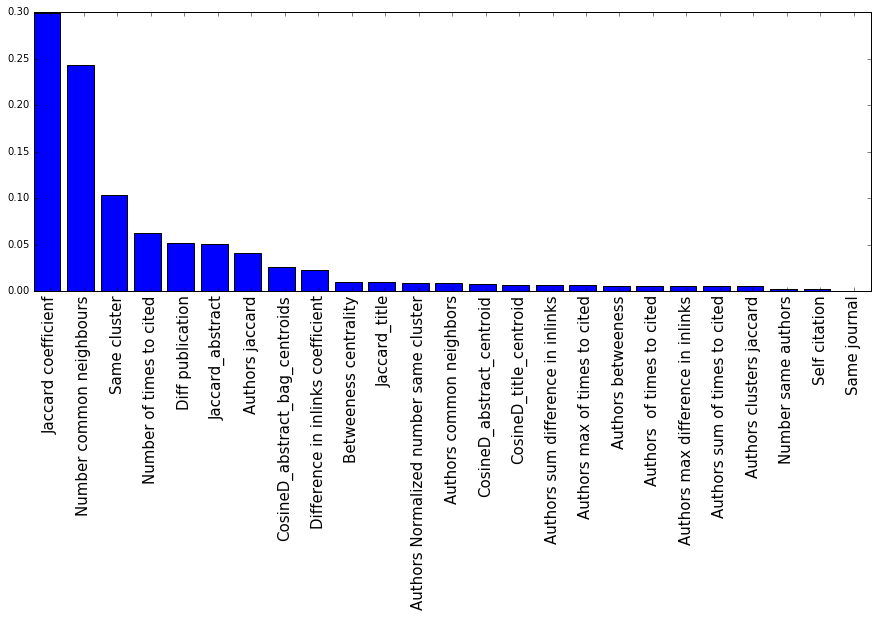

In [40]:
plt.figure(figsize=(15, 5))
X_columns = X_train.drop([0,1], axis = 1).columns
ordering = np.argsort(rfc.feature_importances_)[::-1]

importances = rfc.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

In [ ]:
%%time 
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators = 400,n_jobs=2)
etc.fit(X_train.drop([0,1], axis = 1), y_train)
pred = etc.predict(X_test.drop([0,1], axis = 1))
print score(pred, y_test)
print score(etc.predict(X_train.drop([0,1], axis = 1)),y_train)

In [ ]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators = 300, max_depth = 7)
gbc.fit(X_train.drop([0,1], axis = 1), y_train)
pred = gbc.predict(X_test.drop([0,1], axis = 1))
print score(pred, y_test)
print score(gbc.predict(X_train.drop([0,1], axis = 1)),y_train)

In [ ]:
plt.figure(figsize=(15, 5))
X_columns = X_train.columns
ordering = np.argsort(gbc.feature_importances_)[::-1]

importances = gbc.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

In [ ]:
%%time 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
clf =  Pipeline([
    ("scaler", MinMaxScaler()),
    ("regression",LogisticRegression(C=200000,max_iter = 1000))
    ])
clf.fit(X_train.drop([0,1], axis = 1), y_train)
pred = clf.predict(X_test.drop([0,1], axis = 1))
print score(pred, y_test)
print score(clf.predict(X_train.drop([0,1], axis = 1)),y_train)

In [ ]:
def make_submission(predicted_label, name = 'submit.csv'):
    submit_d = d = {'id' : pd.Series(np.arange(1,X_test.shape[0]+1).astype(int)),
                    'category' : pd.Series(predicted_label).astype(int)}
    submit = pd.DataFrame(submit_d)
    submit.to_csv(name,index=False)
    return submit
